In [37]:
import numpy as np
from bs4 import BeautifulSoup
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

METADATA = {'Contributor': 'T. Dunn'}
SAVEFIGS = True

In [111]:
# Setup template and html config for plotly figures.
import plotly.graph_objects as go

TFB_TEMPLATE = dict(
    layout=go.Layout(
        template='plotly_white',
        autosize=False, # must be True to auto-scale when resizing
        margin=dict(l=50, r=25, b=40, t=20, pad=4),
        font=dict(family='sans-serif', size=14),
        hovermode='closest',
        xaxis=dict(
            automargin=False,
            showline=True, 
            linecolor='#444', linewidth=2,
            mirror=True,
            tickmode='linear', ticks='outside',
            minor=dict(tickmode='linear', ticks='outside'),
            zeroline=False,
        ),
        yaxis=dict(
            automargin=False,
            showline=True,
            linecolor='#444',
            linewidth=2,
            mirror=True,
            tickmode='linear', ticks='outside',
            minor=dict(tickmode='linear', ticks='outside'),
            zeroline=False,
        ),
        hoverlabel=dict(align='left'),
    )
)

TFB_CONFIG = {
    'responsive': True, # must be True to auto-scale when resizing
    #'autosizable': True, # doesn't impact auto rescaling
    'showAxisDragHandles': False,
    'displaylogo': False,
    'displayModeBar': 'hover',
    'modeBarButtonsToRemove': [
        'select2d',
        'lasso2d',
        'zoom2d',
        'zoomIn2d',
        'zoomOut2d',
        'pan2d',
        'autoScale2d',
        'hoverClosestCartesian',
        'hoverCompareCartesian',
        'toggleSpikelines',
        'resetScale2d',
    ],
    'toImageButtonOptions': {
        'format': 'png', # one of png, svg, jpeg, webp
        'filename': 'tfb-plot',
        'height': 450,
        'width': 600,
        'scale': 2
    },
}

def save_fig_html(fig, format, name, **kwargs):
    file_name = f'./{name}.html'

    match format:
        case 'large':
            #fig.update_traces(marker=dict(size=6))
            fig.update_layout(font=dict(size=14))
        case 'small':
            fig.update_traces(line_width=1)
            fig.update_shapes(line_width=1)
            fig.update_layout(font=dict(size=10))
            fig.update_annotations(font_size=10)

    fig_html = fig.to_html(
        config=TFB_CONFIG,
        include_plotlyjs=False, 
        full_html=False, 
    )
    fig_soup = BeautifulSoup(fig_html, 'html.parser')
    fig_soup.div['class'] = f'plotly-div-{format}'
    if kwargs.get('style', None):
        fig_soup.div['style'] = kwargs.get('style')
    with open(file_name, 'wb') as fout:
        fout.write(fig_soup.prettify('utf-8'))

In [123]:
# setup functions and data

P0 = 0.65  # Baseline chance to hit
AB0 = 3    # Baseline attack bonus
AC0 = 12   # Baseline armor class
SB0 = -2
DC0 = 12

print((1/(20*P0)))
print(0.25*np.power(1 + (1/(20*P0)), (0 - (AB0 + AC0))))
def effective_XP_exp(row):
    return 0.25*row['HP Mean']*row['DPR Mean']*np.power(1 + (1/(20*P0)), (row['AC'] + row['AB'] - (AB0 + AC0)))

def effective_XP_linear(row):
    return 0.25*row['HP Mean']*row['DPR Mean']*(1 + (1/(20*P0))*(row['AC'] + row['AB'] - (AB0 + AC0)))

def effective_XP_quadratic(row):
    return 0.25*row['HP Mean']*row['DPR Mean']*(1 + (1/(20*P0))*(row['AC'] - AC0))*(1 + (1/(20*P0))*(row['AB'] - AB0))

def effective_XP2_exp(row):
    return 0.25*row['HP Mean']*row['DPR Mean']*np.power(1 + (1/(20*P0)), (row['AC'] - 14 + row['DC'] - (DC0 + SB0)))

def effective_XP2_linear(row):
    return 0.25*row['HP Mean']*row['DPR Mean']*(1 + (1/(20*P0))*(row['AC'] - 14 + row['DC'] - (DC0 + SB0)))

def effective_XP2_quadratic(row):
    return 0.25*row['HP Mean']*row['DPR Mean']*(1 + (1/(20*P0))*(row['AC'] - 14 - SB0))*(1 + (1/(20*P0))*(row['DC'] - DC0))

# import data
dfD0 = pd.read_csv('../../assets/data/dmg-targets.csv') # 'CR','XP','HP Mean','AC','DPR Mean','AB'
dfD0['eXP exp'] = dfD0.apply(lambda row: effective_XP_exp(row), axis=1)
dfD0['eXP linear'] = dfD0.apply(lambda row: effective_XP_linear(row), axis=1)
dfD0['eXP quadratic'] = dfD0.apply(lambda row: effective_XP_quadratic(row), axis=1)

dfD0['eXP2 exp'] = dfD0.apply(lambda row: effective_XP2_exp(row), axis=1)
dfD0['eXP2 linear'] = dfD0.apply(lambda row: effective_XP2_linear(row), axis=1)
dfD0['eXP2 quadratic'] = dfD0.apply(lambda row: effective_XP2_quadratic(row), axis=1)

0.07692307692307693
0.08225641130103872


In [125]:
# plots XP thresholds for PCs
dfP = pd.read_csv('../../assets/data/pc-thresholds.csv') # 'Level','Easy XP','Medium XP','Hard XP','Deadly XP','Daily XP'

# create figure
fig = go.Figure(
    layout=go.Layout(
        template=TFB_TEMPLATE,
        margin=dict(l=60, r=25, b=55, t=20, pad=4),
        xaxis=dict(
            title_text='level',
            range=[0,21],
            tick0=0, dtick=5,
            minor=dict(tick0=0, dtick=1),
        ),
        yaxis=dict(
            title_text='XP ratio',
            range=[0,7],
            tick0=0, dtick=1,
            minor=dict(tick0=0, dtick=0.5),
        ),
        legend=dict(
            xanchor='left', yanchor='top',
            x=0.00, y=1.00,
            orientation='h',
            tracegroupgap=0,
        )
    )
)

columns = ['Easy','Medium','Hard','Deadly']
columnRef = 'Easy XP'
for c in columns:
    fig.add_trace(go.Scatter(
        x=dfP['Level'], 
        y=dfP[c+' XP']/dfP[columnRef],
        mode='lines+markers', 
        marker=dict(size=4),
        name=c,
        hovertemplate=
            'Level %{x}<br>'+
            'XP ratio %{y:,.1f}' + 
            '<extra></extra>'
    ))
    print('{:} - median {:.2f}'.format(c, np.median(dfP[c+' XP']/dfP[columnRef])))

# show figure
fig.update_layout(width=600, height=500)
fig.show(config=TFB_CONFIG)

# save figures
if SAVEFIGS:
    fig.update_layout(autosize=True, width=None, height=None)
    save_fig_html(fig, format='large', name='fig-pc-xp-thresholds-vs-level-large')
    save_fig_html(fig, format='small', name='fig-pc-xp-thresholds-vs-level-small')

Easy - median 1.00
Medium - median 2.00
Hard - median 3.00
Deadly - median 4.53


In [126]:
# plots XP thresholds for PCs
dfP = pd.read_csv('../../assets/data/pc-thresholds.csv') # 'Level','Easy XP','Medium XP','Hard XP','Deadly XP','Daily XP'
dfP['Encounter XP'] = 7*dfP['Easy XP']

# create figure
fig = go.Figure(
    layout=go.Layout(
        template=TFB_TEMPLATE,
        margin=dict(l=60, r=25, b=55, t=20, pad=4),
        xaxis=dict(
            title_text='level',
            range=[0,21],
            tick0=0, dtick=5,
            minor=dict(tick0=0, dtick=1),
        ),
        yaxis=dict(
            title_text='XP ratio',
            range=[0,1],
            tick0=0, dtick=0.2,
            minor=dict(tick0=0, dtick=0.1),
        ),
        legend=dict(
            xanchor='left', yanchor='top',
            x=0.00, y=1.00,
            orientation='h',
            tracegroupgap=0,
        )
    )
)

columns = ['Easy','Medium','Hard','Deadly']
columnRef = 'Encounter XP'
for c in columns:
    fig.add_trace(go.Scatter(
        x=dfP['Level'], 
        y=dfP[c+' XP']/dfP[columnRef],
        mode='lines+markers', 
        marker=dict(size=4),
        name=c,
        hovertemplate=
            'Level %{x}<br>'+
            'XP ratio %{y:,.2f}' + 
            '<extra></extra>'
    ))
    print('{:} - median {:.2f}'.format(c, np.median(dfP[c+' XP']/dfP[columnRef])))

# show figure
fig.update_layout(width=600, height=500)
fig.show(config=TFB_CONFIG)

# save figures
if SAVEFIGS:
    fig.update_layout(autosize=True, width=None, height=None)
    save_fig_html(fig, format='large', name='fig-pc-xp-thresholds-vs-level-large')
    save_fig_html(fig, format='small', name='fig-pc-xp-thresholds-vs-level-small')

Easy - median 0.14
Medium - median 0.29
Hard - median 0.43
Deadly - median 0.65


In [128]:
# Shows how the calculated XP for typical monsters of each CR compare with listed XP values
dfD = dfD0[dfD0['CR'].gt(1/8)]

columns = ['eXP exp','eXP linear']
labels = ['exponential', 'linear']

# create figure
fig = go.Figure(
    layout=go.Layout(
        template=TFB_TEMPLATE,
        margin=dict(l=60, r=25, b=55, t=20, pad=4),
        xaxis=dict(
            title_text='challenge rating',
            range=[-1,31],
            tick0=0, dtick=5,
            minor=dict(tick0=0, dtick=1),
        ),
        yaxis=dict(
            title_text='XP ratio',
            range=[0.0,1.7],
            tick0=0, dtick=0.2,
            minor=dict(tick0=0, dtick=0.1),
        ),
        legend=dict(
            xanchor='left', yanchor='top',
            x=0.00, y=1.00,
            orientation='v',
            tracegroupgap=0,
        )
    )
)

for column, label in zip(columns, labels):
    fig.add_trace(go.Scatter(
        x=dfD['CR'], 
        y=dfD[column]/dfD['XP'],
        mode='lines',
        name=label,
        hovertemplate=
            'Level %{x}<br>'+
            'XP ratio %{y:,.2f}' + 
            '<extra></extra>'
    ))


fig.add_trace(go.Scatter(
    x=dfD['CR'], 
    y=[1.0]*len(dfD['CR']),
    mode='lines',
    line=dict(color='black', dash='dash'),
    showlegend=False,
    hoverinfo='skip',
))

# show figure
fig.update_layout(width=600, height=500)
fig.show(config=TFB_CONFIG)

# save figures
if SAVEFIGS:
    fig.update_layout(autosize=True, width=None, height=None)
    save_fig_html(fig, format='large', name='fig-effective-xp-ratio-vs-cr-large')
    save_fig_html(fig, format='small', name='fig-effective-xp-ratio-vs-cr-small')

In [130]:
# Shows how the calculated XP for typical monsters of each CR compare with listed XP values
dfD = dfD0[dfD0['CR'].gt(1/8)]

columns = ['eXP2 exp','eXP2 linear','eXP2 quadratic']
labels = ['exponential', 'linear', 'quadratic']

# create figure
fig = go.Figure(
    layout=go.Layout(
        template=TFB_TEMPLATE,
        margin=dict(l=60, r=25, b=55, t=20, pad=4),
        xaxis=dict(
            title_text='challenge rating',
            range=[-1,31],
            tick0=0, dtick=5,
            minor=dict(tick0=0, dtick=1),
        ),
        yaxis=dict(
            title_text='XP ratio',
            range=[0.0,1.7],
            tick0=0, dtick=0.2,
            minor=dict(tick0=0, dtick=0.1),
        ),
        legend=dict(
            xanchor='left', yanchor='bottom',
            x=0.00, y=0.00,
            orientation='v',
            tracegroupgap=0,
        )
    )
)

for column, label in zip(columns, labels):
    fig.add_trace(go.Scatter(
        x=dfD['CR'], 
        y=dfD[column]/dfD['XP'],
        mode='lines',
        name=label,
        hovertemplate=
            'Level %{x}<br>'+
            'XP ratio %{y:,.2f}' + 
            '<extra></extra>'
    ))


fig.add_trace(go.Scatter(
    x=dfD['CR'], 
    y=[1.0]*len(dfD['CR']),
    mode='lines',
    line=dict(color='black', dash='dash'),
    showlegend=False,
    hoverinfo='skip',
))

# show figure
fig.update_layout(width=600, height=500)
fig.show(config=TFB_CONFIG)

In [133]:
# Shows how the calculated XP for typical monsters of each CR compare with listed XP values

# create figure
fig = go.Figure(
    layout=go.Layout(
        template=TFB_TEMPLATE,
        margin=dict(l=60, r=25, b=55, t=20, pad=4),
        xaxis=dict(
            title_text='AB + AC',
            range=[14,34],
            tick0=0, dtick=2,
            minor=dict(tick0=0, dtick=1),
        ),
        yaxis=dict(
            title_text='XP / HP x DPR',
            range=[0,1.6],
            tick0=0, dtick=0.2,
            minor=dict(tick0=0, dtick=0.1),
        ),
        legend=dict(
            xanchor='left', yanchor='top',
            x=0.00, y=1.00,
            orientation='v',
            tracegroupgap=0,
        )
    )
)

dfD = dfD0[dfD0['CR'].gt(1)]

fig.add_trace(go.Scatter(
    #x=dfD['CR'], 
    x=(dfD['AB'] + dfD['AC']),
    y=4*dfD['XP']/(dfD['HP Mean']*dfD['DPR Mean']) - 1,
    mode='markers',
    showlegend=False,
    hoverinfo='skip',
))

coefs = np.polyfit((dfD['AB'] + dfD['AC']), 4*dfD['XP']/(dfD['HP Mean']*dfD['DPR Mean']) - 1, 1)
poly = np.poly1d(coefs)
print(coefs)
print(1/coefs[0])
print(coefs[1]/coefs[0])

fig.add_trace(go.Scatter(
    x=(dfD['AB'] + dfD['AC']),
    y=poly((dfD['AB'] + dfD['AC'])),
    mode='lines',
    line=dict(color='black', dash='dash'),
    showlegend=False,
    hoverinfo='skip',
))

fig.add_trace(go.Scatter(
    x=(dfD['AB'] + dfD['AC']),
    y=((dfD['AB'] + dfD['AC']) - 15)/13,
    mode='lines',
    line=dict(color='red', dash='dash'),
    showlegend=False,
    hoverinfo='skip',
))

# show figure
fig.update_layout(width=600, height=500)
fig.show(config=TFB_CONFIG)

[ 0.07901223 -1.20424979]
12.656269214594166
-15.241309506916567


In [134]:
# An example encounter diagram to illustrate what the encounter multiplier represents.
x_mins  = [0, 9, 13]
y_mins  = [0, 7, 13]
widths  = [9, 4,  3]
heights = [7, 6,  3]
color_diag = 'white'
color_bot = 'red'
color_top = 'blue'

# create figure
fig = go.Figure(
    layout=go.Layout(
        template=TFB_TEMPLATE,
        margin=dict(l=15, r=15, b=15, t=15, pad=4),
        #margin=dict(autoexpand=True),
        dragmode=False,
        xaxis=dict(
            range=[-1.5,17.5],
            mirror=False,
            showgrid=False,
            showline=False,
            zeroline=False,
            showticklabels=False,
            ticks='', minor=dict(ticks=''),
        ),
        yaxis=dict(
            range=[-1.5,17.5],
            mirror=False,
            showgrid=False,
            showline=False,
            zeroline=False,
            showticklabels=False,
            ticks='', minor=dict(ticks=''),
        ),
    )
)

# create diagram
for i in range(3):
    for j in range(3):
        if i < j:
            fc = color_top
            ls = 'dash'
        elif i > j:
            fc = color_bot
            ls = 'dash'
        else:
            fc = 'white'
            ls = 'solid'

        fig.add_shape(type="rect",
            x0=x_mins[i], y0=y_mins[j], x1=x_mins[i]+widths[i], y1=y_mins[j]+heights[j],
            line=dict(color='rgba(250,250,250,0)'),
            fillcolor=fc,
            opacity=0.3,
        )

        if ls == 'solid':
            fig.add_shape(type="rect",
                x0=x_mins[i], y0=y_mins[j], x1=x_mins[i]+widths[i], y1=y_mins[j]+heights[j],
                line=dict(color='black', dash=ls),
                fillcolor=None,
            )

        fig.add_annotation(
            x=x_mins[i] + 0.5*widths[i], 
            y=y_mins[j] + 0.5*heights[j],
            showarrow=False,
            text=f'$\mathit{{XP}}_{{{j+1},{i+1}}}$',
        )

# add reference lines
def add_reference_line(fig, x, y):
    fig.add_trace(go.Scatter(
        x=x, y=y,
        mode='lines',
        line=dict(color='black', dash='dash'),
        showlegend=False, 
        hoverinfo='skip',
    ))

for i in range(3):
    add_reference_line(fig, x=[0, 16], y=[y_mins[i],y_mins[i]])
    add_reference_line(fig, x=[x_mins[i],x_mins[i]], y=[0, 16])
add_reference_line(fig, x=[ 0, 16], y=[16, 16])
add_reference_line(fig, x=[16, 16], y=[ 0, 16])

# add axis labels
for i in range(3):
    # y-axis
    fig.add_annotation(
        x=-0.7, y=y_mins[i] + 0.5*heights[i],
        showarrow=False,
        text=f'$\mathit{{eHP}}_{{{i+1}}}$',
        textangle=-90,
    )
    # x-axis
    fig.add_annotation(
        x=x_mins[i] + 0.5*widths[i], y=-0.7,
        showarrow=False,
        text=f'$\mathit{{eDPR}}_{{{i+1}}}$',
    )

# show figure
fig.update_layout(width=600, height=600)
fig.show(config=TFB_CONFIG)

# save figures
if SAVEFIGS:
    fig.update_layout(autosize=True, width=None, height=None)
    save_fig_html(fig, format='large', name='fig-xp-encounter-diagram-large', style='aspect-ratio: 600/600;')
    save_fig_html(fig, format='small', name='fig-xp-encounter-diagram-small', style='aspect-ratio: 600/600;')

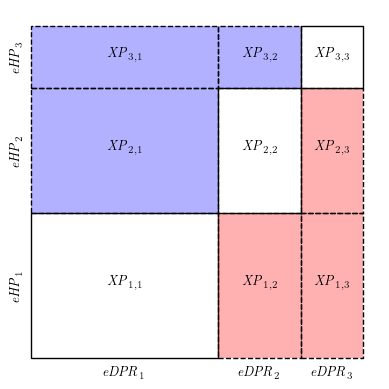

In [6]:
# An example encounter diagram to illustrate what the encounter multiplier represents.
from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

FSIZE = [5,4]
FDPI = 100

plt.rcParams['text.usetex'] = True

x_mins  = [0, 9, 13]
y_mins  = [0, 7, 13]
widths  = [9, 4,  3]
heights = [7, 6,  3]
color_diag = 'w'
color_bot = 'r'
color_top = 'b'

fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes()

for i in range(3):
    for j in range(3):
        if i < j:
            fc = color_top
            ls = '--'
        elif i > j:
            fc = color_bot
            ls = '--'
        else:
            fc = 'white'
            ls = '-'

        rectangle = plt.Rectangle((x_mins[i],y_mins[j]), widths[i], heights[j], fc=fc, ec='none', alpha=0.3)
        ax.add_patch(rectangle)

        rectangle = plt.Rectangle((x_mins[i],y_mins[j]), widths[i], heights[j], fc='none', ec='black', linestyle=ls)
        ax.add_patch(rectangle)

        ax.text(x_mins[i] + 0.5*widths[i], y_mins[j] + 0.5*heights[j], 
            r'$\mathit{{XP}}_{{{:},{:}}}$'.format(j+1,i+1), fontsize=10, ha='center')

for i in range(3):
    ax.text(x_mins[i] + 0.5*widths[i], -0.7, r'$\mathit{{eDPR}}_{{{:}}}$'.format(i+1), fontsize=10, ha='center', va='center')

for j in range(3):
    ax.text(-0.7, (y_mins[j] + 0.5*heights[j]), r'$\mathit{{eHP}}_{{{:}}}$'.format(j+1), fontsize=10, ha='center', va='center', rotation='vertical')

#ax.text(8.0, -0.7, r'$\mathit{eDPR}$', fontsize=12, ha='center', va='center')
#ax.text(-0.7, 8.0, r'$\mathit{eHP}$', fontsize=12, ha='center', va='center', rotation='vertical')
plt.axis('off')
plt.axis('scaled')

if SAVEFIGS: plt.savefig('./fig-xp-encounter-diagram.svg', metadata=METADATA)

plt.rcParams['text.usetex'] = False
